<a href="https://colab.research.google.com/github/6862-2021SP-team3/nflows/blob/master/NewMoon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6.862 Team 3
## Machine Learning Enhancements to Particle Physics Simulations to Reduce Computational Complexity

We fork [https://github.com/bayesiains/nflows](https://github.com/bayesiains/nflows) and apply the MAF techinque to generate $\mathbf{x}$ following unknown the target distribution $p(\mathbf{x})$. The normalizing flow transforms the known base distribution $p(\mathbf{z})$ into $p(\mathbf{x})$. The MAF is one of existing flow models.

## Loading libraries
We assume this jupyter notebook is deployed in google colab.

In [1]:
#copy files from dropbox 
!wget -O pi0.pkl https://www.dropbox.com/s/hrdhr5o1khtclmy/pi0.pkl?dl=0

--2021-04-20 20:13:53--  https://www.dropbox.com/s/hrdhr5o1khtclmy/pi0.pkl?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/hrdhr5o1khtclmy/pi0.pkl [following]
--2021-04-20 20:13:53--  https://www.dropbox.com/s/raw/hrdhr5o1khtclmy/pi0.pkl
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5dd439d91a14ed6cb7ffa536db.dl.dropboxusercontent.com/cd/0/inline/BM-LiMS3nvrrkvx5klatcFf3tGrrTUcySwrKq0tY1BULzGONeG6HZr2tSD63ihQA1fo_I1ptR4iHTpVSWRqrKGOPhnp3uBcMbq7WzxutdNEhz0AXH7uxLq58ZkS0qzrtDv1D5mXLXJ5xI67vNlE-nZOt/file# [following]
--2021-04-20 20:13:54--  https://uc5dd439d91a14ed6cb7ffa536db.dl.dropboxusercontent.com/cd/0/inline/BM-LiMS3nvrrkvx5klatcFf3tGrrTUcySwrKq0tY1BULzGONeG6HZr2tSD63ihQA1fo_I1ptR4iHTpVSWRqrKGOPhnp3uBcMbq7W

In [2]:
#Install module needed to unpack the downloaded data
!pip3 install pickle5
import pickle5 as pickle

In [3]:
!pip install nflows

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn.datasets as datasets
import itertools
import numpy as np
%matplotlib inline
from datetime import datetime
from scipy.stats import entropy
from scipy.stats import wasserstein_distance
from scipy.spatial import distance


import torch
from torch import nn
from torch import optim

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.distributions.normal import DiagonalNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

## Define the data class


The data class reads the downloaded `pi0.pkl` and save them in the varaiable `xz`, `x`, `z`. The `x` and `z` contains encoded particle codes, which are not necessary for the flow model. The `xwithoutPid` and `zwithoutPid` are the varaiables don't contain particle codes for one row. The method `sample` is defined to pick partial rows in given size, where the row indices are randomized.

In [5]:
#Create data class
class dataXZ:
  """
  read the data stored in pickle format
  the converting routine is at https://github.com/6862-2021SP-team3/hipo2pickle
  """
  def __init__(self, standard = False):
    with open('pi0.pkl', 'rb') as f:
        xz = np.array(pickle.load(f), dtype=np.float32)
        #xz = xz[:, 1:]
        # z = xz[:, 16:]
        x = cartesian_converter(xz)
        # x = x[:, [0,4,8,12]]
        x = x[:, [3,7,11,15]]
        #x = xz[:, :16]
        #xwithoutPid = x[:, [0, 1, 2, 4, 5, 6, 8, 9, 10, 12, 13, 14]]
        #xwithoutPid = x[:, [0,  4, 8, 12, ]]
        xwithoutPid = x
        #xwithoutPid = x[:, [0, 1, 4, 5, 8, 12, ]]
        # zwithoutPid = z[:, [0, 1, 2, 4, 5, 6, 8, 9, 10, 12, 13, 14]]
        self.xz = xz
        self.x = torch.from_numpy(np.array(x))
        # self.z = torch.from_numpy(np.array(z))
        self.xwithoutPid = torch.from_numpy(xwithoutPid)
        # self.zwithoutPid = torch.from_numpy(zwithoutPid)

    if standard:
      self.standardize()

  def standardize(self):
    self.xMu = self.xwithoutPid.mean(0)
    self.xStd = self.xwithoutPid.std(0)
    self.zMu = self.zwithoutPid.mean(0)
    self.zStd = self.zwithoutPid.std(0)
    self.xwithoutPid = (self.xwithoutPid - self.xMu) / self.xStd
    self.zwithoutPid = (self.zwithoutPid - self.zMu) / self.zStd

  def restore(self, data, type = "x"):
    mu = self.xMu
    std = self.xStd
    if type == "z":
      mu = self.zMu
      std = self.zStd
    return data * std + mu

  def sample(self, n):
        randint = np.random.randint( self.xz.shape[0], size =n)
        xz = self.xz[randint]
        x = self.x[randint]
        # z = self.z[randint]
        xwithoutPid = self.xwithoutPid[randint]
        # zwithoutPid = self.zwithoutPid[randint]
        # return {"xz":xz, "x": x, "z": z, "xwithoutPid": xwithoutPid, "zwithoutPid": zwithoutPid}
        return {"xz":xz, "x": x, "xwithoutPid": xwithoutPid}

In [6]:
#returns an nx16 array, of energy, px, py, pz, for electron, proton, g1, g2
#You should just pass it the xz object from the dataXZ() class
def cartesian_converter(xznp):
  #split into electron, proton, gammas
  e_vec = xznp[:,1:5]
  p_vec = xznp[:,5:9]
  g1_vec = xznp[:,9:13]
  g2_vec = xznp[:,13:17]

  mass_e = .000511
  mass_p = 0.938
  mass_g = 0

  particles = [e_vec,p_vec,g1_vec,g2_vec]
  masses = [mass_e,mass_p,mass_g,mass_g]

  parts_new = []
  #convert from spherical to cartesian
  for part_vec, mass in zip(particles,masses):
    mom = part_vec[:,0]
    thet = part_vec[:,1]*np.pi/180
    phi = part_vec[:,2]*np.pi/180

    pz = mom*np.cos(thet)
    px = mom*np.sin(thet)*np.cos(phi)
    py = mom*np.sin(thet)*np.sin(phi)
    p2 = pz*pz+px*px+py*py
    E = np.sqrt(mass**2+p2)
    
    x_new = np.array([E,px,py,pz])
    parts_new.append(x_new)

  #reshape output into 1x16 arrays for each event
  e = parts_new[0]
  p = parts_new[1]
  g1 = parts_new[2]
  g2 = parts_new[3]
  out = np.concatenate((e.T,p.T,g1.T,g2.T), axis=1)

  return out

In [7]:
# Define device to be used
dev = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(dev)
print(dev)

cuda:0


In [8]:
#read the data, with the defined data class
xz = dataXZ()
x = xz.x

In [9]:
#debug the data class.
sampleDict = xz.sample(2) 
print(sampleDict["x"])

tensor([[2.8602, 0.5770, 5.2485, 1.4757],
        [5.8933, 0.3362, 2.8420, 1.1460]])


In [10]:
sampleDict = xz.sample(100000) #Get a subset of the datapoints
x = sampleDict["x"]
x = x.detach().numpy()

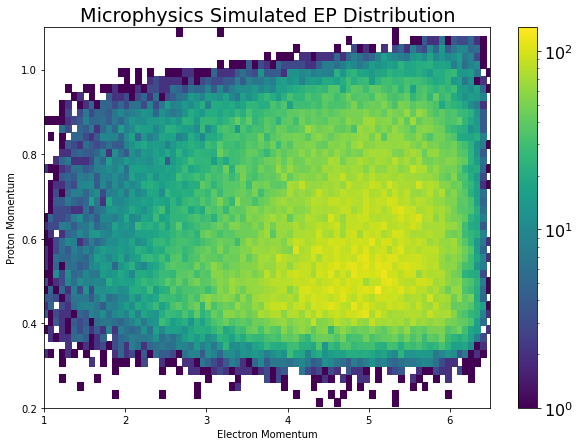

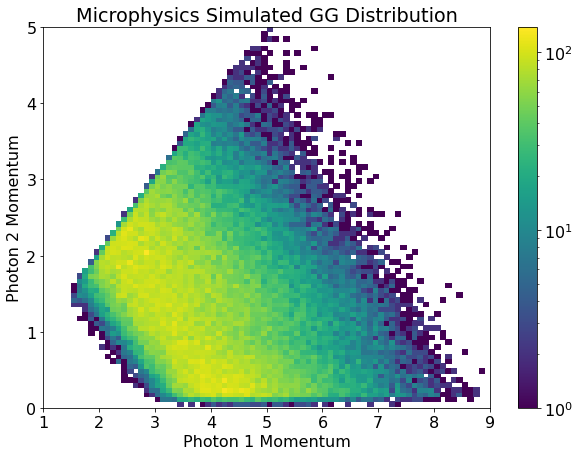

In [11]:
#visualize the data
bin_size = [80,80]
fig, ax = plt.subplots(figsize =(10, 7)) 
plt.rcParams["font.size"] = "16"
ax.set_xlabel("Electron Momentum")  
ax.set_ylabel("Proton Momentum")
plt.title('Microphysics Simulated EP Distribution')

plt.hist2d(x[:,0], x[:,1],bins =bin_size,norm=mpl.colors.LogNorm())# cmap = plt.cm.nipy_spectral) 
plt.xlim([1,6.5])
plt.ylim([0.2,1.1])
plt.colorbar()



fig, ax = plt.subplots(figsize =(10, 7)) 
plt.rcParams["font.size"] = "16"
ax.set_xlabel("Photon 1 Momentum")  
ax.set_ylabel("Photon 2 Momentum")
plt.title('Microphysics Simulated GG Distribution')
plt.hist2d(x[:,2], x[:,3],bins =bin_size,norm=mpl.colors.LogNorm())# cmap = plt.cm.nipy_spectral) 
plt.xlim([1,9])
plt.ylim([0,5])
plt.colorbar()


## Construct a model
We try with a 4d example, electron momentum magnitude and polar angle only. The prior can be any constant distributions, or the parent distributions of `z`. At this stage, we look into the proof of concept, starting with 2d constant distribution. We firstly use the logistic distribution, which can be inverse transform sampled from sigmoid distribution. We pick Adam as our optimizer.

In [12]:
num_layers = 10#12
base_dist = StandardNormal(shape=[4])
#base_dist = DiagonalNormal(shape=[3])
transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=4))
    transforms.append(MaskedAffineAutoregressiveTransform(features=4, 
                                                          hidden_features=20))
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist).to(device)
optimizer = optim.Adam(flow.parameters())
print("number of params: ", sum(p.numel() for p in flow.parameters()))

number of params:  19480


## Define some classes to visualize and evaluate the nflow models.
We plot the distribution of each feature in the same axis. We evalute the distribution in terms of how close they are. The closeness is quantified by some metrics like KL divergence, Wasserstein distance, and Jensen-Sahnnon divergence.

In [13]:
def plot_histo_1D(real_vals, gen_vals, label_real="Physics Data", label_gen="NFlow Model", col2 = "blue",title="Physics vs NFlow Models", saveloc=None):
    fig, axes = plt.subplots(1, 4, figsize=(4*5, 5))
    for INDEX, ax in zip((0, 1, 2,3 ), axes):
        _, bins, _ = ax.hist(real_vals[:, INDEX], bins=100, color = "red", label=label_real, density=True)
        ax.hist(gen_vals[:, INDEX], bins=bins, label=label_gen, color = col2,alpha=0.5, density=True)
        ax.legend(loc="lower left")
        ax.set_title("Feature {}".format(INDEX) )
    plt.tight_layout()
    if saveloc is not None: plt.savefig(saveloc)
    plt.show()

def meter(dist1,dist2,feature):
  kld = entropy(dist1[:,feature],dist2[:,feature])
  emd = wasserstein_distance(dist1[:,feature],dist2[:,feature])
  jsd = distance.jensenshannon(dist1[:,feature],dist2[:,feature]) ** 2
  return [kld, emd, jsd]

## Training step.

We have 1k training steps, each of which uses 1k random sample training data sets. We visualize the training loss and the metrics for the distributions.

Start Time = 20:14:29


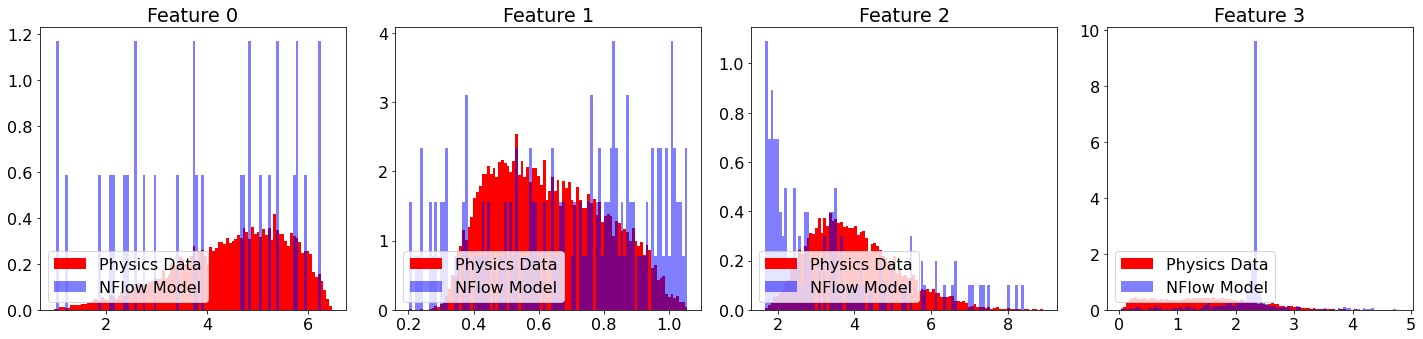

KL Divergence Values: F0: inf  F1: inf  F2: inf 
On step 90 - loss 2.71, Current Running Time = 4.85 seconds
EM Distance   Values: F0: 0.14356  F1: 0.03010  F2: 0.16788 F3: 0.37237 
On step 100 - loss 2.72, Current Running Time = 5.15 seconds
EM Distance   Values: F0: 386.87260  F1: 0.02274  F2: 0.17982 F3: 0.13903 


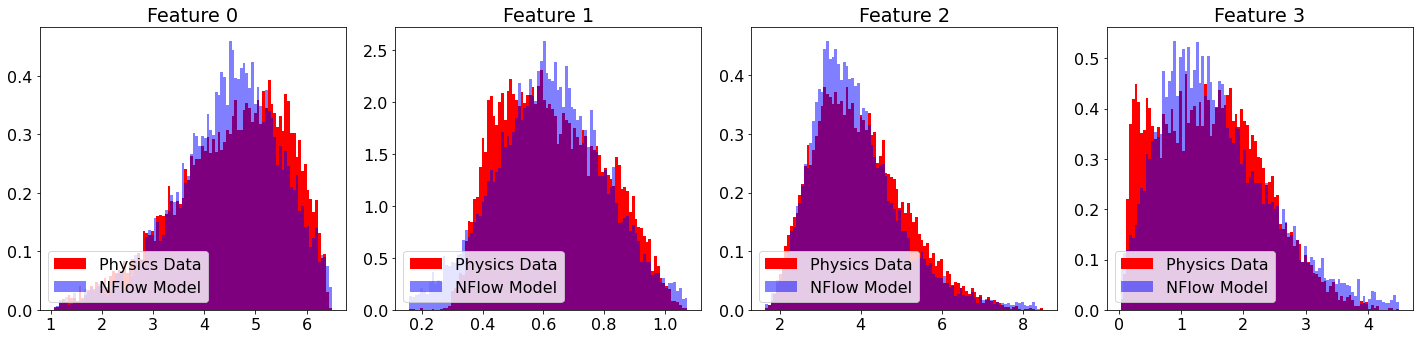

KL Divergence Values: F0: inf  F1: inf  F2: 0.09096 
On step 110 - loss 2.55, Current Running Time = 7.47 seconds
EM Distance   Values: F0: 0.10917  F1: 0.02440  F2: 0.13280 F3: 0.10653 
On step 120 - loss 2.60, Current Running Time = 7.78 seconds
EM Distance   Values: F0: 0.10710  F1: 0.01750  F2: 0.15140 F3: 0.10969 
On step 130 - loss 2.48, Current Running Time = 8.09 seconds
EM Distance   Values: F0: 0.10875  F1: 0.01883  F2: 0.09453 F3: 0.08281 
On step 140 - loss 2.46, Current Running Time = 8.39 seconds
EM Distance   Values: F0: 0.08644  F1: 0.01310  F2: 0.07536 F3: 0.10146 
On step 150 - loss 2.34, Current Running Time = 8.71 seconds
EM Distance   Values: F0: 0.08911  F1: 0.01418  F2: 0.09397 F3: 0.08962 
On step 160 - loss 2.37, Current Running Time = 9.01 seconds
EM Distance   Values: F0: 0.10172  F1: 0.01528  F2: 0.08192 F3: 0.08432 
On step 170 - loss 2.37, Current Running Time = 9.32 seconds
EM Distance   Values: F0: 0.07958  F1: 0.01162  F2: 0.05710 F3: 0.11136 
On step 1

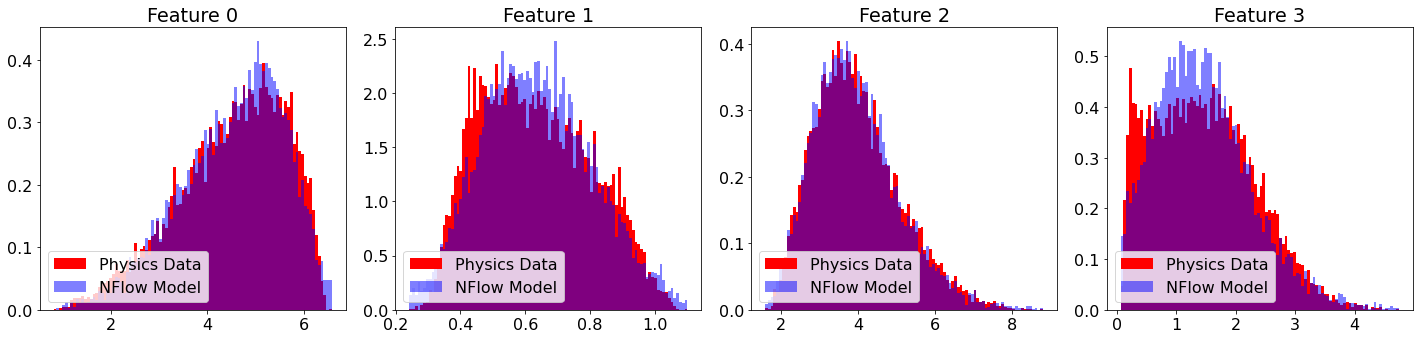

KL Divergence Values: F0: inf  F1: 0.07611  F2: 0.07713 
On step 210 - loss 2.34, Current Running Time = 12.54 seconds
EM Distance   Values: F0: 0.06023  F1: 0.01746  F2: 0.03949 F3: 0.06727 
On step 220 - loss 2.33, Current Running Time = 12.86 seconds
EM Distance   Values: F0: 0.05816  F1: 0.01352  F2: 0.04116 F3: 0.07874 
On step 230 - loss 2.31, Current Running Time = 13.18 seconds
EM Distance   Values: F0: 0.14284  F1: 0.01344  F2: 0.11156 F3: 0.07564 
On step 240 - loss 2.29, Current Running Time = 13.50 seconds
EM Distance   Values: F0: 0.07958  F1: 0.01901  F2: 0.04056 F3: 0.08799 
On step 250 - loss 2.37, Current Running Time = 13.81 seconds
EM Distance   Values: F0: 0.13241  F1: 0.01376  F2: 0.03012 F3: 0.10560 
On step 260 - loss 2.24, Current Running Time = 14.11 seconds
EM Distance   Values: F0: 0.04730  F1: 0.01316  F2: 0.03363 F3: 0.07537 
On step 270 - loss 2.33, Current Running Time = 14.42 seconds
EM Distance   Values: F0: 0.06590  F1: 0.01248  F2: 0.05712 F3: 0.07908

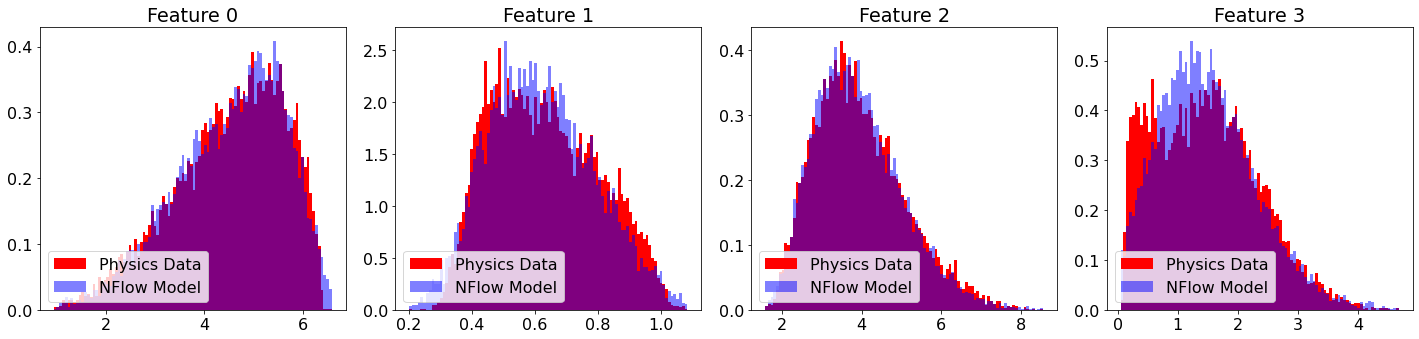

KL Divergence Values: F0: inf  F1: 0.07530  F2: 0.07728 
On step 310 - loss 2.37, Current Running Time = 17.70 seconds
EM Distance   Values: F0: 0.03531  F1: 0.01328  F2: 0.02946 F3: 0.09172 
On step 320 - loss 2.29, Current Running Time = 18.01 seconds
EM Distance   Values: F0: 0.04832  F1: 0.01247  F2: 0.04244 F3: 0.07714 
On step 330 - loss 2.32, Current Running Time = 18.31 seconds
EM Distance   Values: F0: 0.02179  F1: 0.01452  F2: 0.03954 F3: 0.08125 
On step 340 - loss 2.28, Current Running Time = 18.62 seconds
EM Distance   Values: F0: 0.04073  F1: 0.01032  F2: 0.02584 F3: 0.07749 
On step 350 - loss 2.28, Current Running Time = 18.95 seconds
EM Distance   Values: F0: 0.07943  F1: 0.01344  F2: 0.03148 F3: 0.06335 
On step 360 - loss 2.27, Current Running Time = 19.28 seconds
EM Distance   Values: F0: 0.03233  F1: 0.00872  F2: 0.04419 F3: 0.08473 
On step 370 - loss 2.33, Current Running Time = 19.59 seconds
EM Distance   Values: F0: 0.04150  F1: 0.01158  F2: 0.03333 F3: 0.08525

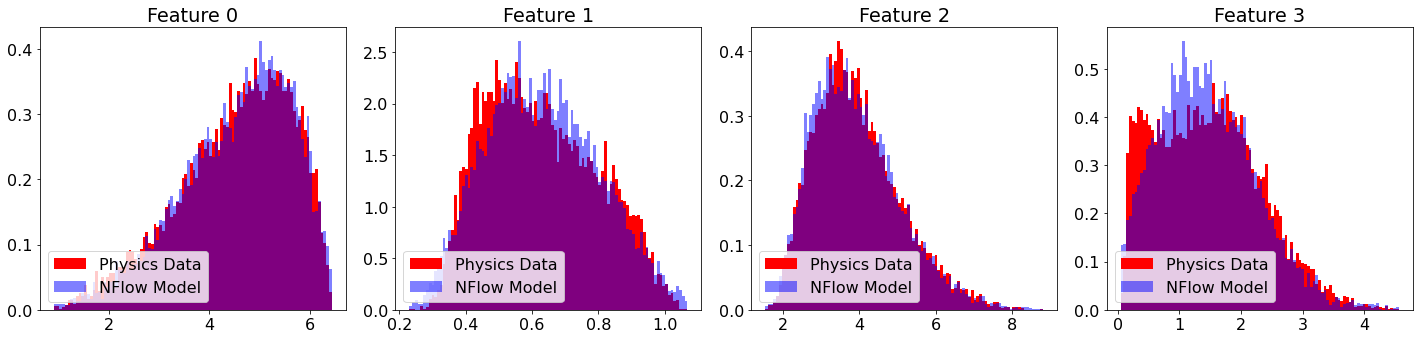

KL Divergence Values: F0: inf  F1: 0.07311  F2: 0.07850 
On step 410 - loss 2.30, Current Running Time = 22.82 seconds
EM Distance   Values: F0: 0.10363  F1: 0.01346  F2: 0.03140 F3: 0.07829 
On step 420 - loss 2.30, Current Running Time = 23.12 seconds
EM Distance   Values: F0: 0.04039  F1: 0.01238  F2: 0.04669 F3: 0.09107 
On step 430 - loss 2.28, Current Running Time = 23.42 seconds
EM Distance   Values: F0: 0.08299  F1: 0.01249  F2: 0.05122 F3: 0.06521 
On step 440 - loss 2.22, Current Running Time = 23.74 seconds
EM Distance   Values: F0: 0.02996  F1: 0.01511  F2: 0.02732 F3: 0.06110 
On step 450 - loss 2.32, Current Running Time = 24.04 seconds
EM Distance   Values: F0: 0.05851  F1: 0.01017  F2: 0.03471 F3: 0.05371 
On step 460 - loss 2.26, Current Running Time = 24.35 seconds
EM Distance   Values: F0: 0.08163  F1: 0.01652  F2: 0.06789 F3: 0.10451 
On step 470 - loss 2.32, Current Running Time = 24.66 seconds
EM Distance   Values: F0: 0.12983  F1: 0.00899  F2: 0.05625 F3: 0.07310

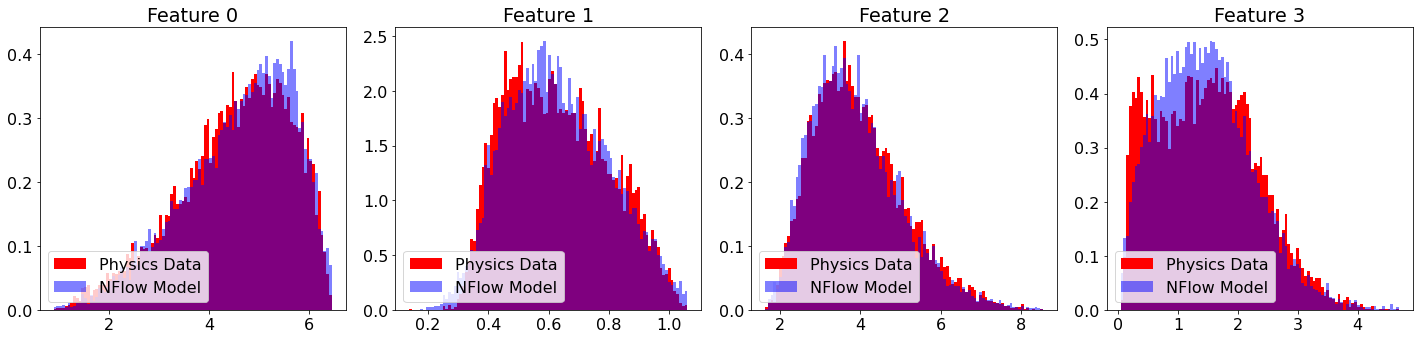

KL Divergence Values: F0: inf  F1: 0.07372  F2: 0.08018 
On step 510 - loss 2.23, Current Running Time = 27.93 seconds
EM Distance   Values: F0: 0.06478  F1: 0.01019  F2: 0.03004 F3: 0.05522 
On step 520 - loss 2.23, Current Running Time = 28.24 seconds
EM Distance   Values: F0: 0.02148  F1: 0.01020  F2: 0.03585 F3: 0.05660 
On step 530 - loss 2.28, Current Running Time = 28.55 seconds
EM Distance   Values: F0: 0.04845  F1: 0.01008  F2: 0.02937 F3: 0.06634 
On step 540 - loss 2.19, Current Running Time = 28.86 seconds
EM Distance   Values: F0: 0.05404  F1: 0.01328  F2: 0.02159 F3: 0.08866 
On step 550 - loss 2.25, Current Running Time = 29.18 seconds
EM Distance   Values: F0: 0.03063  F1: 0.01019  F2: 0.02094 F3: 0.04828 
On step 560 - loss 2.24, Current Running Time = 29.49 seconds
EM Distance   Values: F0: 0.04460  F1: 0.00924  F2: 0.01821 F3: 0.04846 
On step 570 - loss 2.25, Current Running Time = 29.80 seconds
EM Distance   Values: F0: 0.09867  F1: 0.01047  F2: 0.05056 F3: 0.06279

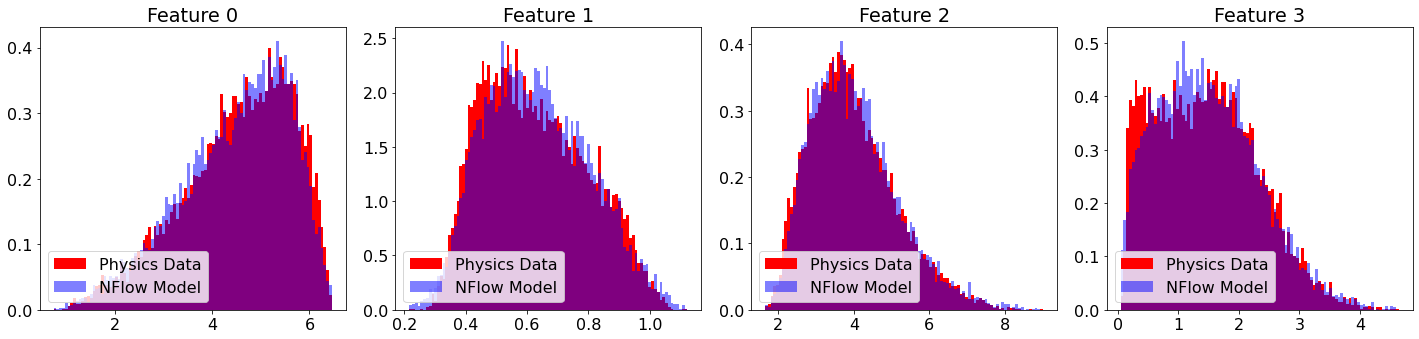

KL Divergence Values: F0: 0.07429  F1: 0.07339  F2: 0.08030 
On step 610 - loss 2.19, Current Running Time = 33.04 seconds
EM Distance   Values: F0: 0.03387  F1: 0.00884  F2: 0.04787 F3: 0.06267 
On step 620 - loss 2.23, Current Running Time = 33.35 seconds
EM Distance   Values: F0: 0.08961  F1: 0.00850  F2: 0.01478 F3: 0.05863 
On step 630 - loss 2.21, Current Running Time = 33.67 seconds
EM Distance   Values: F0: 0.06169  F1: 0.00891  F2: 0.06573 F3: 0.03829 
On step 640 - loss 2.15, Current Running Time = 33.98 seconds
EM Distance   Values: F0: 0.09225  F1: 0.00828  F2: 0.04983 F3: 0.04653 
On step 650 - loss 2.21, Current Running Time = 34.29 seconds
EM Distance   Values: F0: 0.10962  F1: 0.00960  F2: 0.06286 F3: 0.02589 
On step 660 - loss 2.27, Current Running Time = 34.59 seconds
EM Distance   Values: F0: 0.04224  F1: 0.02148  F2: 0.05047 F3: 0.04857 
On step 670 - loss 2.20, Current Running Time = 34.91 seconds
EM Distance   Values: F0: 0.03759  F1: 0.01461  F2: 0.07642 F3: 0.0

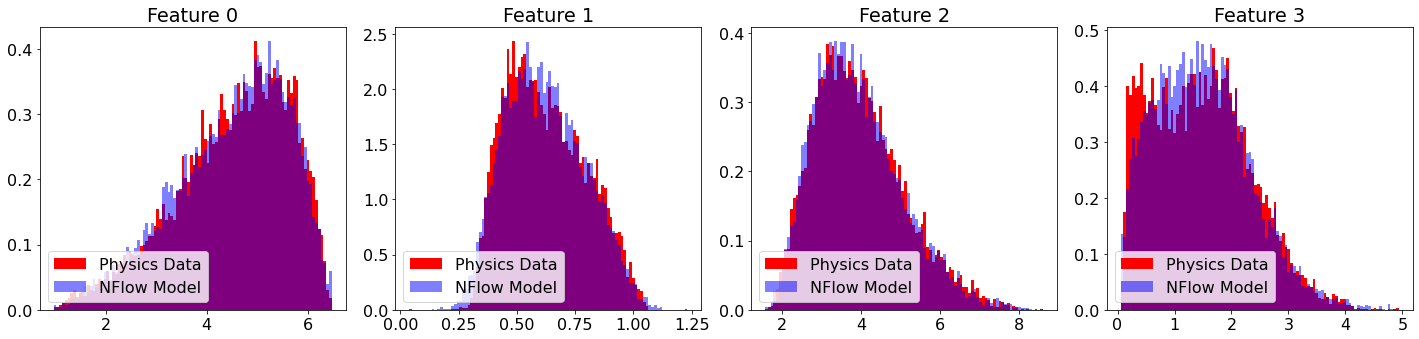

KL Divergence Values: F0: 0.07098  F1: 0.07494  F2: 0.07905 
On step 710 - loss 2.21, Current Running Time = 38.03 seconds
EM Distance   Values: F0: 0.02950  F1: 0.01303  F2: 0.04399 F3: 0.06653 
On step 720 - loss 2.17, Current Running Time = 38.33 seconds
EM Distance   Values: F0: 0.02866  F1: 0.01269  F2: 0.06705 F3: 0.02357 
On step 730 - loss 2.21, Current Running Time = 38.64 seconds
EM Distance   Values: F0: 0.03369  F1: 0.00694  F2: 0.04615 F3: 0.03193 
On step 740 - loss 2.24, Current Running Time = 38.95 seconds
EM Distance   Values: F0: 0.02916  F1: 0.00624  F2: 0.04211 F3: 0.02394 
On step 750 - loss 2.26, Current Running Time = 39.26 seconds
EM Distance   Values: F0: 0.03870  F1: 0.01003  F2: 0.03768 F3: 0.02712 
On step 760 - loss 2.24, Current Running Time = 39.58 seconds
EM Distance   Values: F0: 0.07671  F1: 0.00939  F2: 0.02469 F3: 0.06793 
On step 770 - loss 2.11, Current Running Time = 39.89 seconds
EM Distance   Values: F0: 0.05219  F1: 0.01223  F2: 0.03940 F3: 0.0

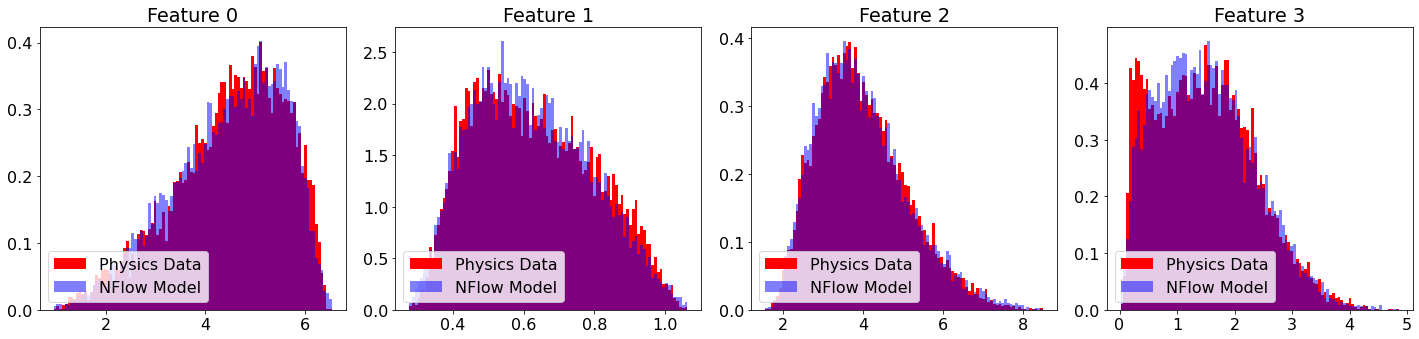

KL Divergence Values: F0: inf  F1: 0.07388  F2: 0.07851 
On step 810 - loss 2.16, Current Running Time = 43.16 seconds
EM Distance   Values: F0: 0.03775  F1: 0.00756  F2: 0.08053 F3: 0.06408 
On step 820 - loss 2.18, Current Running Time = 43.47 seconds
EM Distance   Values: F0: 0.03111  F1: 0.00831  F2: 0.02371 F3: 0.02502 
On step 830 - loss 2.16, Current Running Time = 43.78 seconds
EM Distance   Values: F0: 0.04757  F1: 0.00973  F2: 0.05355 F3: 0.02199 
On step 840 - loss 2.15, Current Running Time = 44.11 seconds
EM Distance   Values: F0: 0.02311  F1: 0.00867  F2: 0.03578 F3: 0.05057 
On step 850 - loss 2.13, Current Running Time = 44.42 seconds
EM Distance   Values: F0: 0.02130  F1: 0.00637  F2: 0.04906 F3: 0.02268 
On step 860 - loss 2.13, Current Running Time = 44.74 seconds
EM Distance   Values: F0: 0.02820  F1: 0.00572  F2: 0.04984 F3: 0.02922 
On step 870 - loss 2.21, Current Running Time = 45.05 seconds
EM Distance   Values: F0: 0.04835  F1: 0.00713  F2: 0.02324 F3: 0.02587

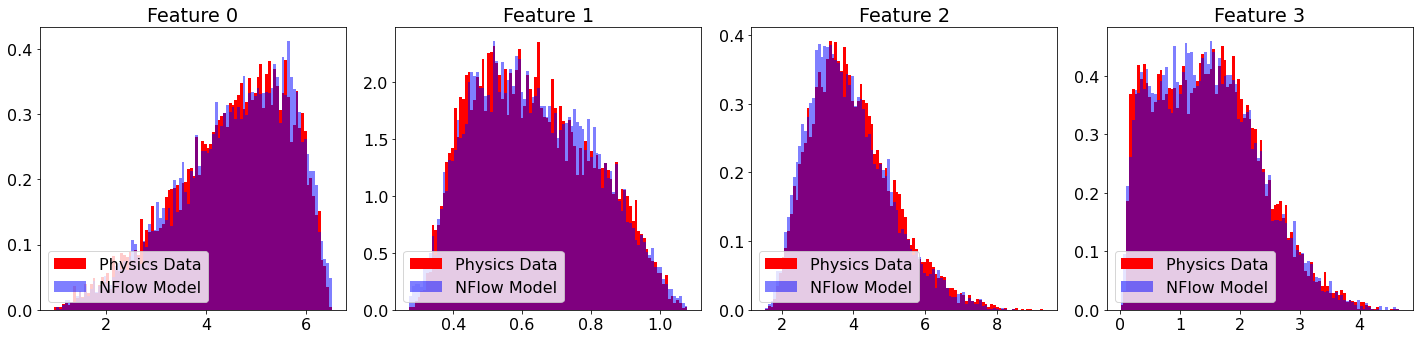

KL Divergence Values: F0: 0.07149  F1: 0.07675  F2: 0.08046 
On step 910 - loss 2.19, Current Running Time = 48.35 seconds
EM Distance   Values: F0: 0.02997  F1: 0.01445  F2: 0.08545 F3: 0.06715 
On step 920 - loss 2.21, Current Running Time = 48.68 seconds
EM Distance   Values: F0: 0.02694  F1: 0.00505  F2: 0.04118 F3: 0.04696 
On step 930 - loss 2.15, Current Running Time = 49.02 seconds
EM Distance   Values: F0: 0.04853  F1: 0.02114  F2: 0.04709 F3: 0.04520 
On step 940 - loss 2.10, Current Running Time = 49.33 seconds
EM Distance   Values: F0: 0.02904  F1: 0.01014  F2: 0.01780 F3: 0.02003 
On step 950 - loss 2.46, Current Running Time = 49.64 seconds
EM Distance   Values: F0: 0.03662  F1: 0.02704  F2: 0.01729 F3: 0.15824 
On step 960 - loss 2.23, Current Running Time = 49.95 seconds
EM Distance   Values: F0: 0.11352  F1: 0.01353  F2: 0.10561 F3: 0.03158 
On step 970 - loss 2.20, Current Running Time = 50.26 seconds
EM Distance   Values: F0: 0.03452  F1: 0.00641  F2: 0.01118 F3: 0.0

In [14]:
num_iter = 1000
start_now = datetime.now()
start_time = start_now.strftime("%H:%M:%S")
print("Start Time =", start_time)
losses = []
f1_kd = []
f1_em = []
f1_js = []
f2_em = []
f3_em = []

for i in range(num_iter):
    # x, y = datasets.make_moons(12, noise=.1)
    # x = torch.tensor(x, dtype=torch.float32)
    # print(x)
    # print(y)
    sampleDict = xz.sample(1000)
    x = sampleDict["x"][:, 0:4].to(device)
    #y = sampleDict["xwithoutPid"][:, 1:2] 
    #print(x)
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=x).mean()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())


    if i % 10 == 0:
        run_time = datetime.now()
        elapsedTime = (run_time - start_now )
        
        bbb = 10000
        z= flow.sample(bbb).cpu().detach().numpy()
        sampleDict = xz.sample(bbb)
        x = sampleDict["x"][:, 0:4]
        x = x.detach().numpy()

        #plot_histo_1D(x,z)

        f1 = meter(x,z,0)
        f2 = meter(x,z,1)
        f3 = meter(x,z,2)
        f4 = meter(x,z,3)


        if f1[1]*f2[1]*f3[1]*f4[1] < 1:
          print("On step {} - loss {:.2f}, Current Running Time = {:.2f} seconds".format(i,loss.item(),elapsedTime.total_seconds())) 
          print("EM Distance   Values: F0: {:.5f}  F1: {:.5f}  F2: {:.5f} F3: {:.5f} ".format((f1[1]),(f2[1]),(f3[1]),(f4[1]),))
          #break

        f1_kd.append(f1[0])
        f1_em.append(f1[1])
        f1_js.append(f1[2])
        f2_em.append(f2[1])
        f3_em.append(f3[1])

        if i % 100 == 0:
          bbb = 100000
          zzz= flow.sample(bbb).cpu().detach().numpy()
          sampleDictzz = xz.sample(bbb)
          x = sampleDict["x"]
          x = x.detach().numpy()
          plot_histo_1D(x,z)
          # print("On step {} - loss {:.2f}, Current Running Time = {:.2f} seconds".format(i,loss.item(),elapsedTime.total_seconds())) 
          print("KL Divergence Values: F0: {:.5f}  F1: {:.5f}  F2: {:.5f} ".format((f1[0]),(f2[0]),(f3[0]),))
          # print("EM Distance   Values: F0: {:.5f}  F1: {:.5f}  F2: {:.5f} ".format((f1[1]),(f2[1]),(f3[1]),))
          #print("JS Divergence Values: F0: {:.5f}  F1: {:.5f}  F2: {:.5f} ".format((f1[2]),(f2[2]),(f3[2]),))


now = datetime.now()
end_time = now.strftime("%H:%M:%S")
print("End Time =", end_time)
elapsedTime = (now - start_now )
print("Total Run Time = {:.5f} seconds".format(elapsedTime.total_seconds()))
    # if (i + 1) % 50 == 0:
    #     xline = torch.linspace(-1.5, 2.5)
    #     yline = torch.linspace(-.75, 1.25)
    #     xgrid, ygrid = torch.meshgrid(xline, yline)
    #     xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

    #     with torch.no_grad():
    #         zgrid = flow.log_prob(xyinput).exp().reshape(100, 100)

    #     plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())
    #     plt.title('iteration {}'.format(i + 1))
    #     plt.show()

Text(0, 0.5, 'Kullback–Leibler Divergence')

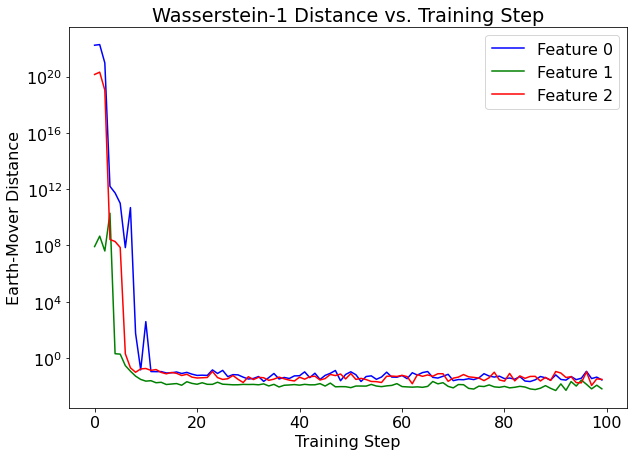

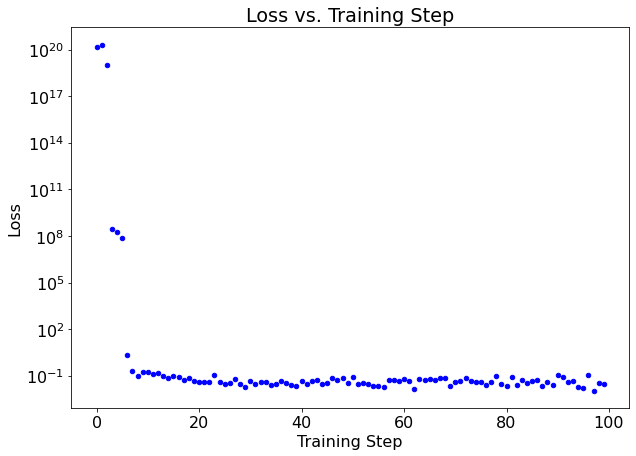

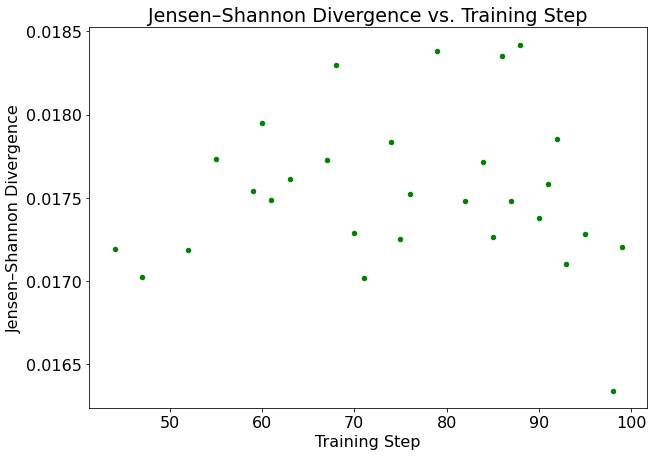

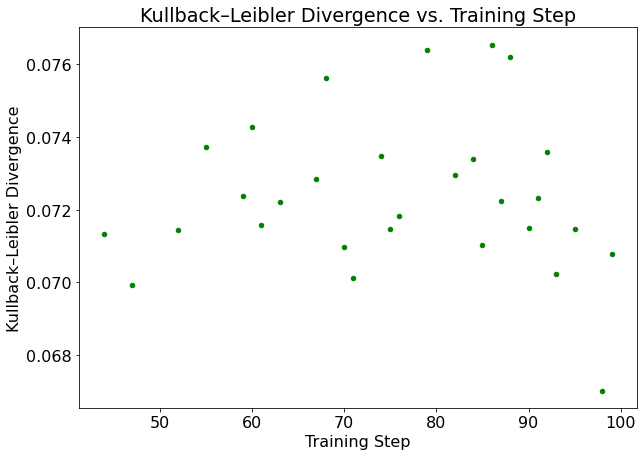

In [15]:
#f1_kd = []
#f1_em = []
#f1_js = []

fig, ax = plt.subplots(figsize =(10, 7)) 
#print(np.arange(len(losses)))
plt.rcParams["font.size"] = "16"

plt.plot(np.arange(len(f1_em)),f1_em, '-b',label="Feature 0")
plt.plot(np.arange(len(f1_em)),f2_em, '-g',label="Feature 1")
plt.plot(np.arange(len(f1_em)),f3_em, '-r',label="Feature 2")
#plt.ylim([1000000000,0.0001])
ax.set_yscale('log')
plt.title('Wasserstein-1 Distance vs. Training Step')
ax.legend()
ax.set_xlabel("Training Step")  
ax.set_ylabel("Earth-Mover Distance")


fig, ax = plt.subplots(figsize =(10, 7)) 
#print(np.arange(len(losses)))
plt.rcParams["font.size"] = "16"

plt.scatter(np.arange(len(f1_em)),f3_em, c='b', s=20)
#plt.ylim([1000000000,0.0001])
ax.set_yscale('log')
plt.title('Loss vs. Training Step')
ax.set_xlabel("Training Step")  
ax.set_ylabel("Loss")

fig, ax = plt.subplots(figsize =(10, 7)) 
#print(np.arange(len(losses)))
plt.rcParams["font.size"] = "16"

plt.scatter(np.arange(len(f1_js)),f1_js, c='g', s=20)
#plt.ylim([1000000000,0.0001])
#ax.set_yscale('log')
plt.title('Jensen–Shannon Divergence vs. Training Step')
ax.set_xlabel("Training Step")  
ax.set_ylabel("Jensen–Shannon Divergence")

fig, ax = plt.subplots(figsize =(10, 7)) 
#print(np.arange(len(losses)))
plt.rcParams["font.size"] = "16"

plt.scatter(np.arange(len(f1_kd)),f1_kd, c='g', s=20)
#plt.ylim([1000000000,0.0001])
#ax.set_yscale('log')
plt.title('Kullback–Leibler Divergence vs. Training Step')
ax.set_xlabel("Training Step")  
ax.set_ylabel("Kullback–Leibler Divergence")



## Test step.
We evaluate our model by sampling new $\mathbf{x}$. We calculate the metrics between evaluation data set from NF and physics samples from that we have.

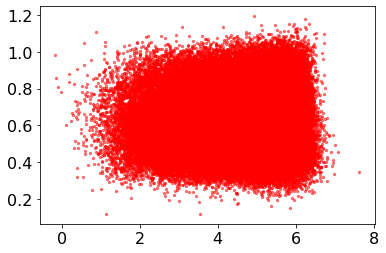

In [16]:
aa = flow.sample(100000).cpu().detach().numpy()

plt.scatter(aa[:,0], aa[:,1], c='r', s=5, alpha=0.5)

z = aa

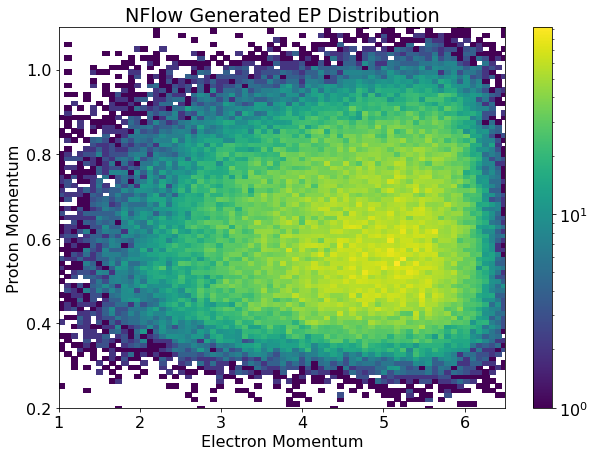

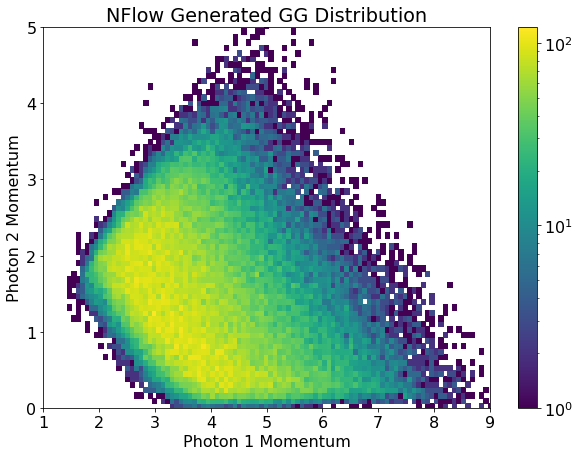

In [17]:
bin_size = [100,100]
fig, ax = plt.subplots(figsize =(10, 7)) 
plt.rcParams["font.size"] = "16"
ax.set_xlabel("Electron Momentum")  
ax.set_ylabel("Proton Momentum")
plt.title('NFlow Generated EP Distribution')

plt.hist2d(z[:,0], z[:,1],bins =bin_size,norm=mpl.colors.LogNorm())# cmap = plt.cm.nipy_spectral) 
plt.xlim([1,6.5])
plt.ylim([0.2,1.1])
plt.colorbar()



fig, ax = plt.subplots(figsize =(10, 7)) 
plt.rcParams["font.size"] = "16"
ax.set_xlabel("Photon 1 Momentum")  
ax.set_ylabel("Photon 2 Momentum")
plt.title('NFlow Generated GG Distribution')
plt.hist2d(z[:,2], z[:,3],bins =bin_size,norm=mpl.colors.LogNorm())# cmap = plt.cm.nipy_spectral) 
plt.xlim([1,9])
plt.ylim([0,5])
plt.colorbar()

In [18]:
bbb = 100000
z= flow.sample(bbb).cpu().detach().numpy()
sampleDict = xz.sample(bbb)
sampleDict2 = xz.sample(bbb)
y = sampleDict2["x"]
y = y.detach().numpy()
x = sampleDict["x"]
x = x.detach().numpy()


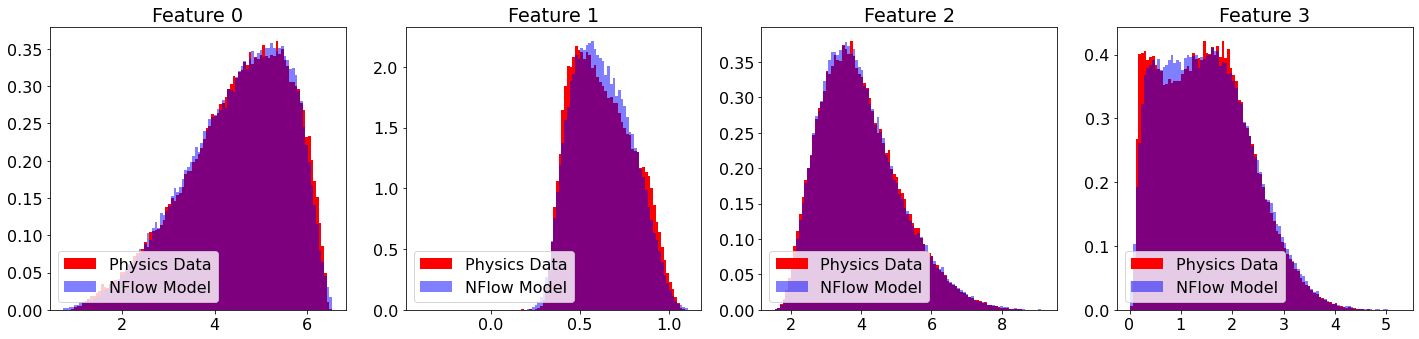

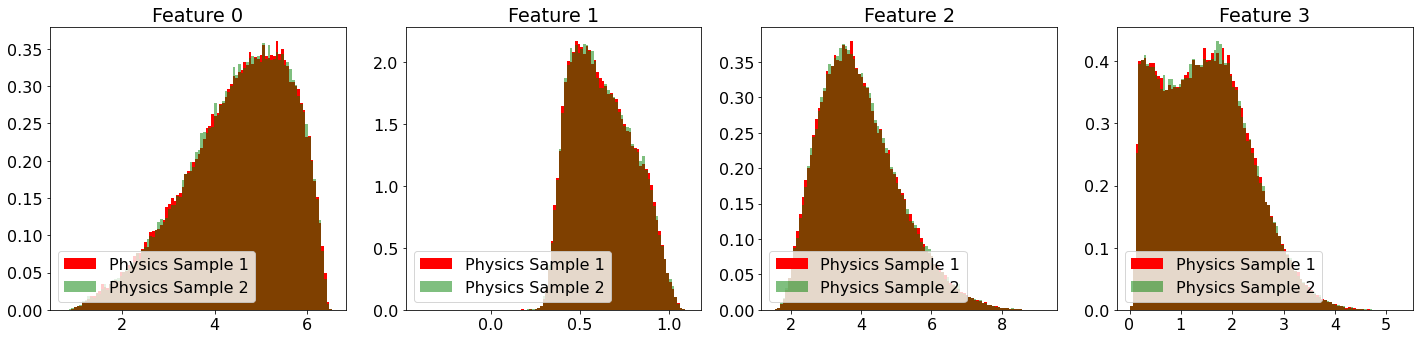

Values for Physics Data vs. NFlow Model:
KL Divergence Values: F0: inf  F1: inf  F2: 0.07871 ,F3: inf  
EM Distance   Values: F0: 0.02015  F1: 0.00864  F2: 0.01442 ,F3: 0.02081 
JS Divergence Values: F0: inf  F1: inf  F2: 0.01935  ,F3: inf 




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in float_scalars
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


Ratio of KL, EM, and JS values from NFlow comparision and two physics model samples:
KL Divergence Ratio: F0: inf  F1: nan  F2: 0.99286 ,F3: inf  
EM Distance   Ratio: F0: 4.78754  F1: 18.84306  F2: 2.37765 ,F3: 7.64385 
JS Divergence Ratio: F0: inf  F1: nan  F2: 0.99459  ,F3: inf 


Values for two samples from physics data
KL Divergence Values: F0: 0.07177  F1: inf  F2: 0.07928 ,F3: 0.39516  
EM Distance   Values: F0: 0.00421  F1: 0.00046  F2: 0.00607 ,F3: 0.00272 
JS Divergence Values: F0: 0.01749  F1: inf  F2: 0.01946  ,F3: 0.08836 


In [19]:
plot_histo_1D(x,z)
plot_histo_1D(x,y,label_real="Physics Sample 1", label_gen="Physics Sample 2",col2="green")

f1 = meter(x,z,0)
f2 = meter(x,z,1)
f3 = meter(x,z,2)
f4 = meter(x,z,3)

print("Values for Physics Data vs. NFlow Model:")
print("KL Divergence Values: F0: {:.5f}  F1: {:.5f}  F2: {:.5f} ,F3: {:.5f}  ".format((f1[0]),(f2[0]),(f3[0]),(f4[0])))
print("EM Distance   Values: F0: {:.5f}  F1: {:.5f}  F2: {:.5f} ,F3: {:.5f} ".format((f1[1]),(f2[1]),(f3[1]),(f4[1])))
print("JS Divergence Values: F0: {:.5f}  F1: {:.5f}  F2: {:.5f}  ,F3: {:.5f} ".format((f1[2]),(f2[2]),(f3[2]),(f4[2])))
print('\n')

f1 = [i / j for i, j in zip(f1,meter(x,y,0))]
f2 = [i / j for i, j in zip(f2,meter(x,y,1))]
f3 = [i / j for i, j in zip(f3,meter(x,y,2))]
f4 = [i / j for i, j in zip(f4,meter(x,y,3))]

print("Ratio of KL, EM, and JS values from NFlow comparision and two physics model samples:")
print("KL Divergence Ratio: F0: {:.5f}  F1: {:.5f}  F2: {:.5f} ,F3: {:.5f}  ".format((f1[0]),(f2[0]),(f3[0]),(f4[0])))
print("EM Distance   Ratio: F0: {:.5f}  F1: {:.5f}  F2: {:.5f} ,F3: {:.5f} ".format((f1[1]),(f2[1]),(f3[1]),(f4[1])))
print("JS Divergence Ratio: F0: {:.5f}  F1: {:.5f}  F2: {:.5f}  ,F3: {:.5f} ".format((f1[2]),(f2[2]),(f3[2]),(f4[2])))
print('\n')

f1 = meter(x,y,0)
f2 = meter(x,y,1)
f3 = meter(x,y,2)
f4x = meter(x,y,3)

print("Values for two samples from physics data")
print("KL Divergence Values: F0: {:.5f}  F1: {:.5f}  F2: {:.5f} ,F3: {:.5f}  ".format((f1[0]),(f2[0]),(f3[0]),(f4x[0])))
print("EM Distance   Values: F0: {:.5f}  F1: {:.5f}  F2: {:.5f} ,F3: {:.5f} ".format((f1[1]),(f2[1]),(f3[1]),(f4x[1])))
print("JS Divergence Values: F0: {:.5f}  F1: {:.5f}  F2: {:.5f}  ,F3: {:.5f} ".format((f1[2]),(f2[2]),(f3[2]),(f4x[2])))


